In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import Markdown, display
from tulip.analysis.equity_related.analytics import *
from tulip.analysis.equity_related.visualization import *
from tulip.utils.notebook_related import *
from tulip.plots import *
import pycountry


Haver path setting remains unchanged.



In [2]:
NOTEBOOK_TITLE = "Japan - MSCI JP"

CTRY = "JPN"
CTRY_EQ_INDEX = "MXJP Index"  # 'TPX Index'
CTRY_GOV = "GTJPY10Y Govt"
CTRY_BEI = "JYGGBE10 Index"
CURRENCY = "JPY Curncy"
GOLDMAN_CTRY = "Japan (SA)"

ERP = 0.02
DIV_PO = 0.5  # Crazy different results for some geographies
INTERCEPT_IN_MODEL_1 = False

In [3]:
# Parameters
NOTEBOOK_TITLE = "Eurozone - SX5E"
CTRY = "EUR"
CTRY_EQ_INDEX = "SX5E Index"
CTRY_GOV = "GTEUR10Y Govt"
CTRY_BEI = "DEGGBE10 Index"
CURRENCY = "EUR Curncy"
GOLDMAN_CTRY = "Euro area (SA)"
ERP = 0.02
DIV_PO = 0.5
INTERCEPT_IN_MODEL_1 = False


In [4]:
BASE_CURRENCY = bb.bdp(CURRENCY, fields=["BASE_CRNCY"])["base_crncy"].squeeze()
PY_CTRY = pycountry.countries.get(alpha_3=CTRY)
if PY_CTRY:
    CTRY_2 = PY_CTRY.alpha_2
else:
    if CURRENCY == "EUR Curncy":
        CTRY_2 = "EU"

## Eurostoxx 50

In [5]:
## ----- Get Data -----
# Get historical EPS and SPS data
BBERG_EPS_FIELD = (
    "IS_DIL_EPS_CONT_OPS" if CTRY in ["USA", "CAN"] else "IS_EARN_BEF_XO_ITEMS_PER_SH"
)
historical_eps = get_historical_eps(
    CTRY_EQ_INDEX, start_date="1992-01-01", eps_field=BBERG_EPS_FIELD
)
historical_sps = get_historical_sps(CTRY_EQ_INDEX, start_date="1992-01-01")

# Get GDP data
NGDP, RGDP = get_gdp_data(CTRY)

# Get daily index data
daily_index_df = get_daily_index_data(CTRY_EQ_INDEX).droplevel(0, axis=1)
daily_index_df["EPS_Delta"] = (
    daily_index_df["BEST_EPS"] - daily_index_df["TRAIL_12M_EPS"]
)
daily_index_df["EPS_Delta_Pct"] = (
    daily_index_df["EPS_Delta"] / daily_index_df["TRAIL_12M_EPS"]
)

# Get yield data
nominal_yield_df, bei_df = get_yield_data(CTRY_GOV, CTRY_BEI)

data_per_q_df = calculate_data_per_q(
    NGDP=NGDP.ts.rename("NGDP"),
    RGDP=RGDP.ts.rename("RGDP"),
    EPS=historical_eps,
    SPS=historical_sps,
    currency=CURRENCY,
    daily_index_df=daily_index_df,
    base_currency=BASE_CURRENCY,
)

nominal_gdp_forecast = get_NGDP_forecast(GOLDMAN_CTRY)

# ----- Compute Reference Dates -----
last_fwd_eps = daily_index_df["BEST_EPS"].tail(1).squeeze()
last_pe = daily_index_df["BEST_PE_RATIO"].tail(1).squeeze()
last_eps = daily_index_df.loc[:, "TRAIL_12M_EPS"].tail(1).squeeze()
last_valid_gdp_q = NGDP.info.observation_end
last_actual_eps = data_per_q_df["EPS"].last_valid_index()
horizon_date = last_actual_eps + pd.offsets.MonthEnd(12)

## ----- Compute IEG -----
ieg = compute_ieg(
    pe_ratio=daily_index_df["BEST_PE_RATIO"],
    nominal_yield=nominal_yield_df.iloc[:, 0],
    bei=bei_df.iloc[:, 0],
    equity_risk_premium=ERP,
    dividend_payout_ratio=DIV_PO,
)

ieg.loc[:, ["NY_10Y", "BEI_10Y", "DY"]] = ieg.loc[:, ["NY_10Y", "BEI_10Y", "DY"]].apply(
    fill_forward
)

ieg_summary = organize_ieg_summary(ieg, covid_start_date, covid_end_date)

#### Valuation


In [6]:
default_x_range = (
    ieg.index[-1] - pd.offsets.MonthEnd(60),
    ieg.index[-1] + pd.offsets.MonthEnd(9),
)
pe_fig = plot_lines(
    daily_index_df["BEST_PE_RATIO"],
    default_x_range=default_x_range,
    title=f"{CTRY} | {CTRY_EQ_INDEX}: FWD PE Ratio",
    source="Bloomberg, Note: Uses the BF methodology",
)

ieg_fig = plot_lines(
    ieg[["NIEG", "RIEG"]].rename(columns={"NIEG": "Nominal", "RIEG": "Real"}),
    tick_format="0.0%",
    title=f"{CTRY} | {CTRY_EQ_INDEX}: Implied Earnings Growth",
    default_x_range=default_x_range,
    source="Bloomberg, Kate Capital",
)

erp_fig = plot_lines(
    ieg["EY-NY"],
    tick_format="0.0%",
    title=f"{CTRY} | {CTRY_EQ_INDEX}: Earnings yield - Nominal yield",
    default_x_range=default_x_range,
    source="Bloomberg, Kate Capital",
)

display_table_and_chart(
    table=style_ieg_summary(ieg_summary),
    chart=pe_fig,
    table_width="50%",
    chart_width="50%",
)

display_two_charts(
    erp_fig,
    ieg_fig,
    chart1_width="50%",
    chart2_width="50%",
    container_width="100%",
)

,PE,EY-NY,Nom. IEG,Real IEG
Last,16.1,3.57%,1.54%,-0.23%
One Month Ago,15.7,3.78%,1.41%,-0.34%
Delta,0.4,-0.21%,0.12%,0.10%
Avg since 86/12,12.4,6.69%,-0.49%,-2.35%
Avg ex. Covid,11.9,6.71%,-0.39%,-2.32%
Last 5Y,13.9,5.79%,-0.10%,-2.02%
Percentile Rank,93.46%,0.73%,91.30%,99.77%


#### Earnings Expectations


In [7]:
eps_summary = calculate_eps_summary(daily_index_df=daily_index_df)
styled_eps_summary = style_eps_summary(
    eps_summary, caption=f"{CTRY} | {CTRY_EQ_INDEX}: EPS Summary"
)

eps_fig = plot_lines(
    daily_index_df[["TRAIL_12M_EPS", "BEST_EPS", "EPS_Delta"]],
    title=f"{CTRY} | {CTRY_EQ_INDEX}: EPS Evolution",
    default_x_range=default_x_range,
    axis_title="EPS",
    source="Bloomberg, Kate Capital",
)

switch_trace_to_secondary_axis(
    eps_fig,
    "EPS_Delta",
    secondary_axis_title="Delta",
    default_y2_range=(0, daily_index_df["EPS_Delta"].max()),
    as_area=True,
)

display_table_and_chart(
    table=styled_eps_summary, chart=eps_fig, table_width="30%", chart_width="70%"
)

,Value
Metric,
Forward EPS,359.55
Trailing EPS,337.34
Exp. Growth,22.21
Exp. Growth (%),6.58%
5Yr EPS Growth,14.18%
Avg Exp. Growth (%),6.32%
Z-Score (Growth %),0.04


#### Positioning

In [8]:
# todo

#### EPS Forecasts

##### **MODEL 0**: We forecast EPS extrapolating historical growth (Naive Baseline)

,EPS Central,Model R-squared
EPS_MODEL_0,346.884088,0.12783


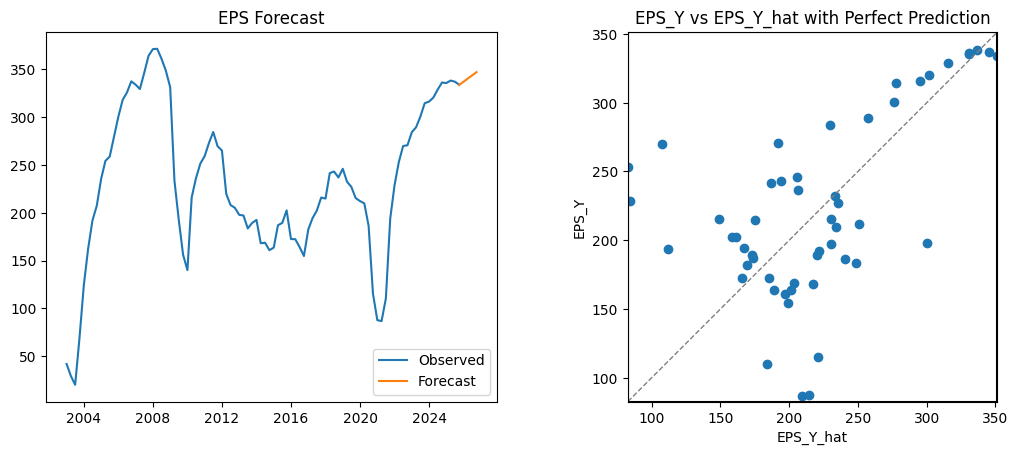

In [9]:
import tulip.analysis.equity_related.eps_forecasts.model_0 as eps_model_0

model_0, act_vs_pred_df, rsq, n_year_cagr = eps_model_0.fit_model(
    actual_q_df=data_per_q_df,
    actual_daily_q=daily_index_df,
    years_lookback=10,
)

model_0_forecast_df = eps_model_0.make_forecast(fitted_model=model_0)

model_0_fig = eps_model_0.plot_forecast(
    forecast_df=model_0_forecast_df, act_vs_pred_df=act_vs_pred_df, figsize=(12.8, 4.8)
)

model_0_summary = eps_model_0.summarize_forecast(
    forecast_df=model_0_forecast_df, rsq=rsq, horizon=horizon_date
)
display(model_0_summary.to_frame("EPS_MODEL_0").T)

##### **MODEL 1**: We forecast EPS_YoY growth quaterly using YoY Historical Nominal GDP Growth and GS Forecasts

,coef,std_err,p_value,CI_lower,CI_upper
NGDP_YoY,2.651433,0.852201,0.002658,0.952999,4.349866


,EPS Lower,EPS Central,EPS Upper,Model R-squared
EPS_MODEL_1,336.036611,340.307848,344.579085,0.659038


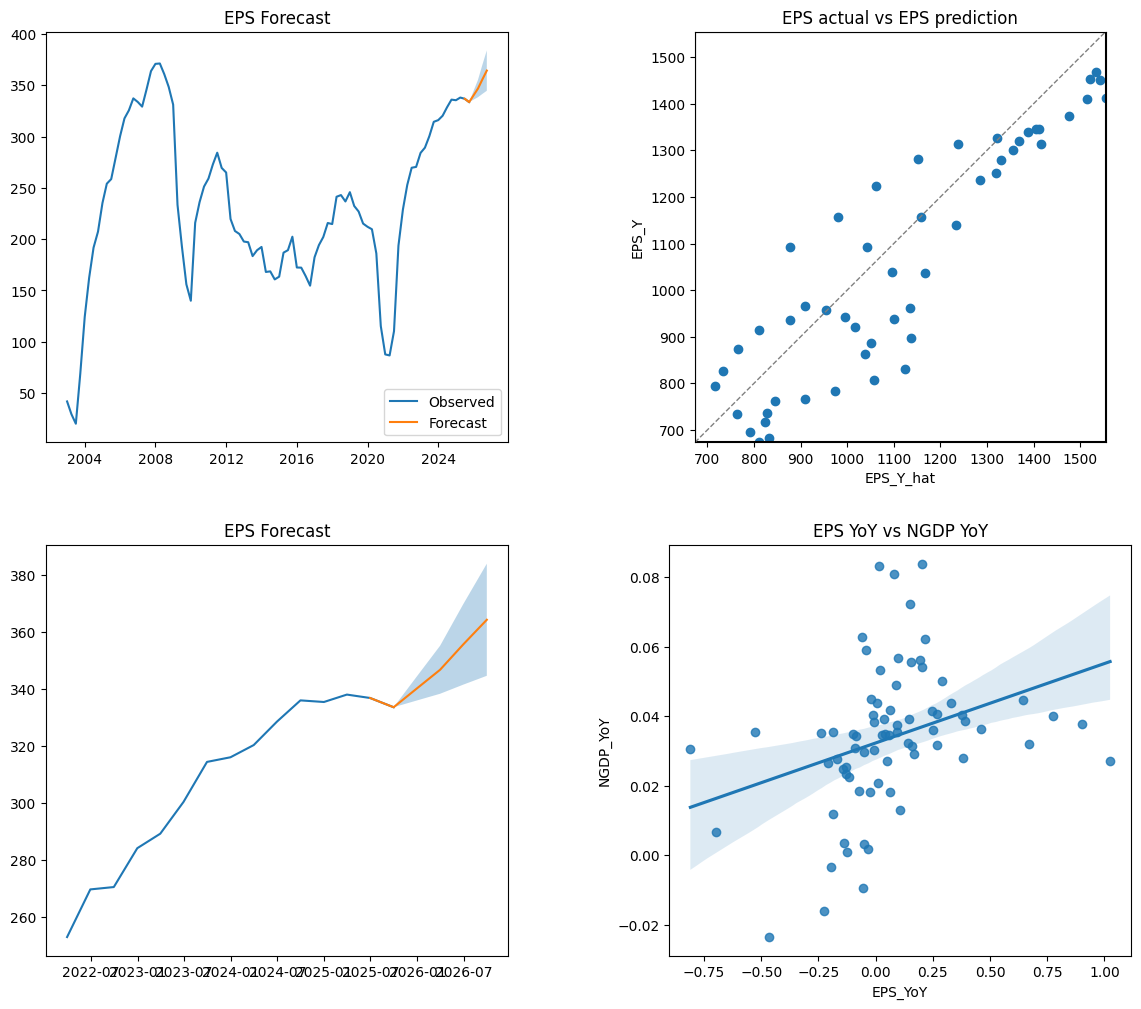

In [10]:
import tulip.analysis.equity_related.eps_forecasts.model_1 as eps_model_1

model_1, act_vs_pred_df, rsq = eps_model_1.fit_model(
    df=data_per_q_df,
    target="EPS_YoY",
    predictors=["NGDP_YoY"],
    clean_outliers=True,
    add_intercept=INTERCEPT_IN_MODEL_1,
)

model_1_forecast_df = eps_model_1.make_forecast(
    fitted_model=model_1,
    data_per_q_df=data_per_q_df,
    nominal_gdp_forecast=nominal_gdp_forecast,
)

model_1_plot = eps_model_1.plot_model_output(
    model_1_forecast_df, data_per_q_df, act_vs_pred_df
)

coefficients = eps_model_1.summarize_coefficients(fitted_model=model_1)
model_1_summary = eps_model_1.summarize_forecast(
    forecast_df=model_1_forecast_df, rsq=rsq
)
display(coefficients)
display(model_1_summary.to_frame("EPS_MODEL_1").T)

##### **MODEL 2**: We forecast EPS by first forecasting SPS and Net Margins using YoY Historical Nominal GDP Growth and GS Forecasts
The evolution of SPS tends to follow changes in NGDP more closely than EPS

,EPS Lower,EPS Central,EPS Upper,Model R-squared
EPS_MODEL_2,319.723334,331.408427,343.371984,0.694335


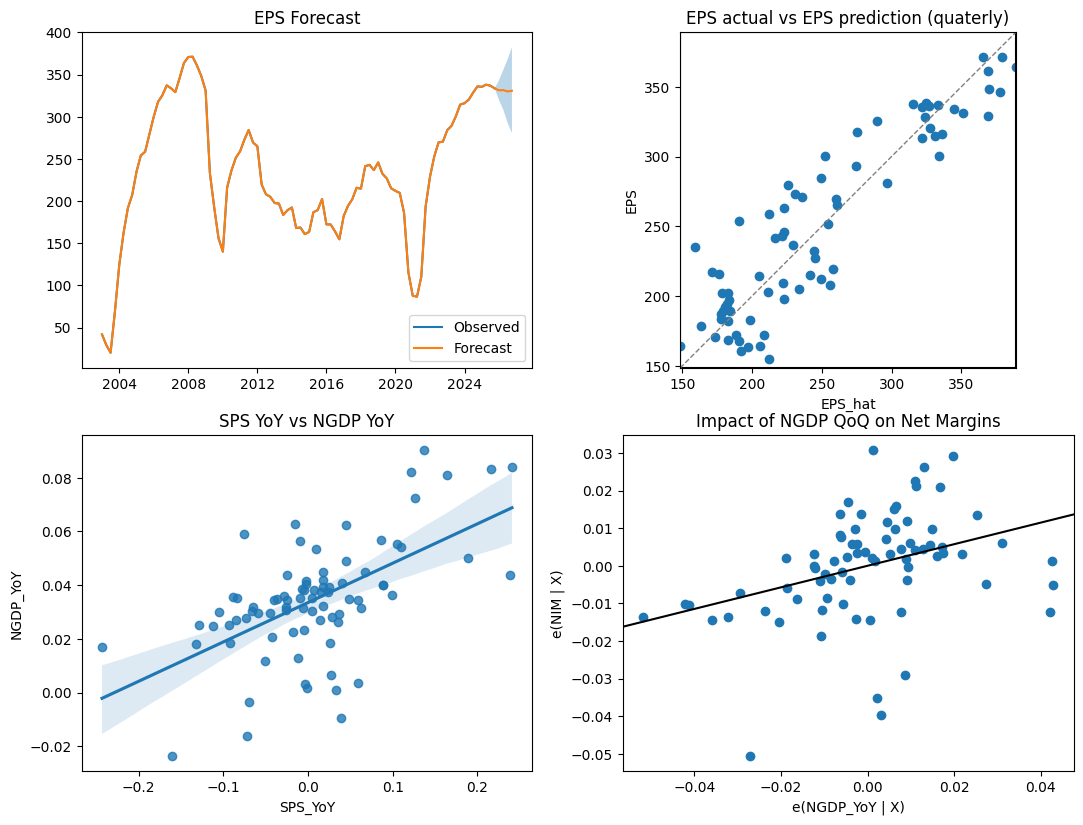

In [11]:
import tulip.analysis.equity_related.eps_forecasts.model_2 as eps_model_2

fitted_sps_model, fitted_nim_model, act_vs_pred_df, rsq = eps_model_2.fit_model(
    df=data_per_q_df, clean_outliers=True, add_intercept=False
)

model_2_forecast_df = eps_model_2.make_forecast(
    fitted_sps_model=fitted_sps_model,
    fitted_nim_model=fitted_nim_model,
    data_per_q_df=data_per_q_df,
    nominal_gdp_forecast=nominal_gdp_forecast,
)

model_2_plot = eps_model_2.plot_output(
    forecast_df=model_2_forecast_df,
    actual_df=data_per_q_df,
    act_vs_pred_df=act_vs_pred_df,
    clean_outliers=True,
    figsize=(12.8, 9.6),
)

model_2_summary = eps_model_2.summarize_forecast(
    forecast_df=model_2_forecast_df, rsq=rsq
)
display(model_2_summary.to_frame("EPS_MODEL_2").T)


##### **EPS Forecast Results**:

In [12]:
summary = pd.DataFrame(
    {
        "Model 0: Extrapolation": model_0_summary,
        "Model 1: Based on EPS YoY": model_1_summary,
        "Model 2: Based on SPS and Margins": model_2_summary,
    }
).T
summary.insert(0, "EPS Expectation", last_fwd_eps)
summary

,EPS Expectation,EPS Central,EPS Lower,EPS Upper,Model R-squared
Model 0: Extrapolation,359.5504,346.884088,NaN,NaN,0.127830
Model 1: Based on EPS YoY,359.5504,340.307848,336.036611,344.579085,0.659038
Model 2: Based on SPS and Margins,359.5504,331.408427,319.723334,343.371984,0.694335


In [13]:
Markdown(f"_Notebook updated at {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}_")

_Notebook updated at 2025-11-12 19:43_